Assuming that the image is scaled to fit the following HOG implementation "8x8 pixel cells and 4x4 cell blocks", I will use the following Batman Logo as an example.

<class 'numpy.ndarray'>
(128, 128, 3)


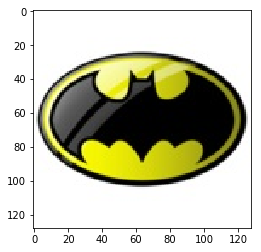

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np

img = imread('test_image.JPG')
print(type(img))
print(img.shape)
plt.imshow(img)
plt.show()
image = np.copy(img)  # will use it later when trying to visulaize cells on the image

Since we aren't allowed to use OpenCV or skimage, Using the formula Y' = 0.299 R + 0.587 G + 0.114 B  to change the picture to greyscale. I used Wikipedis link: https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale to get the formula

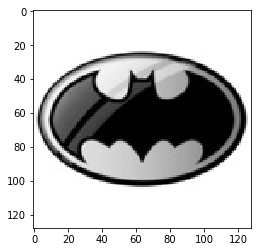

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

gray = rgb2gray(img)    
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

Note that we can work directly on RGB images and we can get pixel gradients for each layer "red, green and blue" then choose the highest gradient as our pixel gradinet image, but at first I will work on grayscale images and if there is stiil time before the deadline, I will try working on RGB images.

# Pixel-Level Feature Maps section 6.1.1 implementation

### 1. Padding the image is vital so that when we create vertical and horizontal filters, we make sure that the center pixel in the filter will be matched with the border pixels in our image. The filters should be of odd number.

The following function will calculate the gradient in any direction based on the filter design, but note that it needs a square filter so that it concentrates on the gradient of the center pixel only.

In [3]:
def get_gradient(img, input_filter):
    fs = input_filter.shape[0] #Number of important elements in the filter is 3
    #New padded array to hold the resultant gradient image.
    new_img = np.zeros((img.shape[0]+fs-1, img.shape[1]+fs-1))
    new_img[np.uint16((fs-1)/2.0):img.shape[0]+np.uint16((fs-1)/2.0), 
            np.uint16((fs-1)/2.0):img.shape[1]+np.uint16((fs-1)/2.0)] = img  # inserted image inside the padded frame
    #so we have the padding such that the filter multiplication starts with the first pixel of the real origional image as
    #its center pixel
    result = np.zeros((new_img.shape))  # this will be the place for the pixel gradients image 
    
    # 'r' denotes rows and 'c' denotes columns
    for r in np.uint16(np.arange((fs-1)/2.0, img.shape[0]+(fs-1)/2.0)):
        for c in np.uint16(np.arange((fs-1)/2.0, img.shape[1]+(fs-1)/2.0)):
            curr_region = new_img[r-np.uint16((fs-1)/2.0):r+np.uint16((fs-1)/2.0)+1, 
                                  c-np.uint16((fs-1)/2.0):c+np.uint16((fs-1)/2.0)+1]  # this region will be a square of 
            #side length equal to the length of the filter
            curr_result = curr_region * input_filter  # element wise multiplication
            g_score = np.sum(curr_result)  # summing the nearest pixels to the center pixel to get its gradient score
            result[r, c] = g_score  # assigning the gradient score to the gradient image
    #Removing the paddings to get the same size as the original image 
    gradient_img = result[np.uint16((fs-1)/2.0):result.shape[0]-np.uint16((fs-1)/2.0), 
                        np.uint16((fs-1)/2.0):result.shape[1]-np.uint16((fs-1)/2.0)]
    return gradient_img

### 2. Calculating gradient in X "horizontal direction", note that I added padding to [-1,0,1] as the get_gradient function area that will be multiplied by the filter is a square

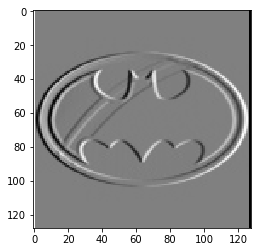

In [4]:
x_filter = np.array([[0,0,0],[-1,0,1],[0,0,0]])
x_gradient_image = get_gradient(gray, x_filter)
plt.imshow(x_gradient_image, cmap = plt.get_cmap('gray'))
plt.show()

note that the the left part of batman logo is balckened and the right part is whitened as rate of change "gradient" calculated is in the horizontal direction

### 3. Calculating gradient in y "vertical direction", note that I added padding to [-1,0,1] as the get_gradient function area that will be multiplied by the filter is a square

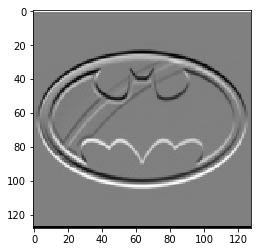

In [5]:
y_filter = np.array([[0,-1,0],[0,0,0],[0,1,0]])
y_gradient_image = get_gradient(gray, y_filter)
plt.imshow(y_gradient_image, cmap = plt.get_cmap('gray'))
plt.show()

note that the the upper part of batman logo is balckened and the lower part is whitened as rate of change "gradient" calculated is in the vertical direction

### 4. Calculating gradient magnitude

The following function is used to calculate the magnitude of the pixel X_vector and Y_vector

In [6]:
def gradient_magnitude(horizontal_gradient, vertical_gradient):
    horizontal_gradient_square = np.power(horizontal_gradient, 2)
    vertical_gradient_square = np.power(vertical_gradient, 2)
    sum_squares = horizontal_gradient_square + vertical_gradient_square
    grad_magnitude = np.sqrt(sum_squares)
    return grad_magnitude

In [7]:
grad_mag_image = gradient_magnitude(x_gradient_image,y_gradient_image)
grad_mag_image.shape

(128, 128)

The following function is used to calculate the angel of the pixel X_vector and Y_vector and we can use the signed or unsigned histograms by toggling the value of variable "signed"

In [8]:
def gradient_direction(horizontal_gradient, vertical_gradient, signed = True):
    grad_direction = np.arctan(vertical_gradient/(horizontal_gradient+0.00000001))
    grad_direction = np.rad2deg(grad_direction)
    grad_direction = grad_direction
    if not signed:
        grad_direction = grad_direction % 180 # removing 180 degrees to change the scale from 360 to 180
    return grad_direction

In [9]:
signed = False  # using unsigned histogram
grad_dir_image = gradient_direction(x_gradient_image,y_gradient_image, signed)  # using unsigned histogram
grad_dir_image.shape

(128, 128)

note that there will be an overlap between 180 and zero angels

In [10]:
np.rad2deg(np.pi)%180

0.0

# Spatial Aggregation section 6.1.2 implementation

### 1. Dividing the image into cells each cell has an area of horizontal_cell_size X vertical_cell_size

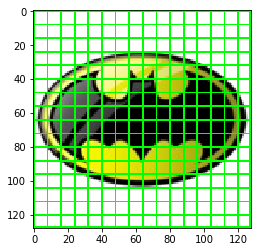

In [11]:
horizontal_cell_size = 8
vertical_cell_size = 8
for r in range(0, image.shape[0],horizontal_cell_size):
    #print(r,r+horizontal_cell_size-1)
    image[r,:]=[0,255,0]
    for c in range(0, image.shape[1],vertical_cell_size):
        #print(c,c+vertical_cell_size-1)
        image[:,c]=[0,255,0]
image[image.shape[0]-1,:]=[0,255,0]  # changing the color of the last row to green 
image[:,image.shape[1]-1]=[0,255,0]  # changing the color of the last column to green
plt.imshow(image)
plt.show()

The target is to make cells that are simillar to the above figure. Now I will create a list that will contain the boundaries of each cell using the start row, end row , start column and end column of each cell

In [12]:
cells = []
def create_cells(image, horizontal_cell_size, vertical_cell_size):
    for r in range(0, image.shape[0],horizontal_cell_size):
        for c in range(0, image.shape[1],vertical_cell_size):
            cells.append([r,r+horizontal_cell_size-1,c,c+vertical_cell_size-1])
    return cells

In [13]:
image_cells_coords = create_cells(image, horizontal_cell_size, vertical_cell_size)
image_cells_coords[0:5]  # displaying first 5 cells "lists" in terms of rows and columns where the first two numbers are 
# the start and end row of the cell and the last two numbers are the start and end columns bounding the cell

[[0, 7, 0, 7], [0, 7, 8, 15], [0, 7, 16, 23], [0, 7, 24, 31], [0, 7, 32, 39]]

### 2. getting the histogram of each cell 

let's try to visualize the Histogram of a cell in the first block.

In [14]:
cell_direction = grad_dir_image[0:8,0:8]
cell_magnitude = grad_mag_image[0:8,0:8]


The following function will get the histogram of the inputted cell. The inputs are the magnitude image and directions of the cell "8 x 8 grouped pixels" and the histogram bins. I got the formula for bilinear interpolation from this paper: https://www2.cs.duke.edu/courses/fall15/compsci527/notes/hog.pdf and covered the rest of the scenarios of the angle of the pixel related to the position of the bins using this paper: https://www.learnopencv.com/histogram-of-oriented-gradients/

In [15]:
def HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins):
    HOG_cell_hist = np.zeros(shape=(hist_bins.size))
    # following loop will be used to pass on magnitude and direction in each pixel inside the cell
    #print(horizontal_cell_size,vertical_cell_size)
    for row_idx in range(horizontal_cell_size):
        for col_idx in range(vertical_cell_size):
            #print(row_idx,col_idx,cell_direction[row_idx, col_idx])
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
            #print("angle is:", curr_direction,"and magnitude is:", curr_magnitude)
            diff = np.abs(curr_direction - hist_bins).tolist()  # get the difference between the pixel angle the bins in a list
            #print(diff)
            nearest_bin_idx = diff.index(min(diff))  # get the index of minimum 
            #print("min number index is:",nearest_bin_idx)
            #########   handling different cases of angles   ###########
            if curr_direction == hist_bins[nearest_bin_idx]:  # handling when the pixel angle is exactly = bin CENTER value
                HOG_cell_hist[nearest_bin_idx] = HOG_cell_hist[nearest_bin_idx] + (abs(curr_direction - first_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
                #print("the angle is: ",curr_direction, " which is exactly bin number: ",nearest_bin_idx)
                continue  # we will skip the following scenarios and we updated the needed bin
                
            if  curr_direction < hist_bins[0]:  # if angle < 10 "my first bin value", the angle is between 170 and 10, here 170 acts as if it's -10
                first_bin_value = hist_bins[-1]
                second_bin_value = hist_bins[0]
                # we know that the angle is neare to 10 as it's least value will be 0
                first_bin_vote = (abs(curr_direction - second_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
                second_bin_vote = curr_magnitude - first_bin_vote
                #print("first bin is: ", first_bin_value,"with vote:",first_bin_vote, "while second bin is: ", second_bin_value,"with vote: ",second_bin_vote)
                HOG_cell_hist[-1] = HOG_cell_hist[-1] + first_bin_vote
                HOG_cell_hist[0] = HOG_cell_hist[0] + second_bin_vote
                continue  # we will skip the following scenarios and we updated the needed bin
                
                
            elif curr_direction > hist_bins[-1]:  # if angle > 170 "my last bin value", the angle is between 170 and 10 which is 190 degrees
                first_bin_value = hist_bins[-1]
                second_bin_value = hist_bins[0]  # note that here  10 degrees act as  if it's 190 for the following formula
                # note that since we know that the maximum angle will be either 180 in unsigned or 360 in signed, so the
                # nearest bin is the last bin "first bin"
                second_bin_vote = (abs(curr_direction - first_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
                first_bin_vote = curr_magnitude - second_bin_vote
                #print("first bin is: ", first_bin_value,"with vote:",first_bin_vote, "while second bin is: ", second_bin_value,"with vote: ",second_bin_vote)
                HOG_cell_hist[-1] = HOG_cell_hist[-1] + first_bin_vote
                HOG_cell_hist[0] = HOG_cell_hist[0] + second_bin_vote
                continue  # we will skip the following scenarios and we updated the needed bin
                
            if curr_direction < hist_bins[nearest_bin_idx]:  # when pixel angle is < nearest bin value, then it lies between this bin and the one before it
                first_bin_idx = nearest_bin_idx - 1
                second_bin_idx = nearest_bin_idx 
                first_bin_value = hist_bins[first_bin_idx]
                second_bin_value = hist_bins[second_bin_idx] 
                # here angle is nearer to second bin, so the bigger distance, i.e. distance between first bin and pixel angle is used to
                # get the vote for the second "nearest" bin as the pixel should vote MORE for the nearest bin
                nearest_bin_vote = (abs(curr_direction - first_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
                far_bin_vote = curr_magnitude - nearest_bin_vote
                #print("first bin is: ", first_bin_value,"with vote:",far_bin_vote, "while second bin is: ", second_bin_value,"with vote: ",nearest_bin_vote)
                HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + nearest_bin_vote
                HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + far_bin_vote
            
            elif curr_direction > hist_bins[nearest_bin_idx]:  # when pixel angle is > nearest bin value, then it lies between this bin and the one after it
                first_bin_idx = nearest_bin_idx 
                second_bin_idx = nearest_bin_idx + 1
                first_bin_value = hist_bins[first_bin_idx]
                second_bin_value = hist_bins[second_bin_idx]
                #print("first bin is: ", first_bin_value, "while second bin is: ", second_bin_value)
                nearest_bin_vote = (abs(curr_direction - second_bin_value)/(180.0/hist_bins.size)) * curr_magnitude
                far_bin_vote = curr_magnitude - nearest_bin_vote
                #print("first bin is: ", first_bin_value,"with vote:",nearest_bin_vote, "while second bin is: ", second_bin_value,"with vote: ",far_bin_vote)
                HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + nearest_bin_vote
                HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + far_bin_vote
                                
    return(HOG_cell_hist)

(8, 8) 
 [[45. 90. 90. 90. 90. 90. 90. 90.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]] 
 the mag: [[360.62445841 255.         255.         255.         255.
  255.         255.         255.        ]
 [255.           0.           0.           0.           0.
    0.           0.           0.        ]
 [255.           0.           0.           0.           0.
    0.           0.           0.        ]
 [255.           0.           0.           0.           0.
    0.           0.           0.        ]
 [255.           0.           0.           0.           0.
    0.           0.           0.        ]
 [255.           0.           0.           0.           0.
    0.           0.           0.        ]
 [255.           0.           0.           0.           0.
    0.           0.           0.  

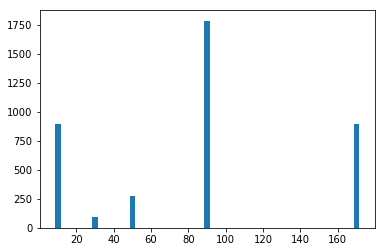

In [16]:
hist_bins = np.array([10,30,50,70,90,110,130,150,170])
print(cell_direction.shape,"\n",cell_direction, "\n the mag:", cell_magnitude)

HOG_cell_hist = HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins)

plt.bar(left=hist_bins, height=HOG_cell_hist, align="center", width=3)
plt.show()

Note that the cell has many Zeors so all their magnitude will be distributed between the first bin "10" and last bin "170" equally, Then we have a few 90s and their magnitude will go directly to the bin of "90" with no distribution, then we have one 45 degree and most of its magnitude will go to the bin of "50" as it's the nearest and some will go the bin of "30". Despite the number of zero angles are bigger than the number of ninety degree angles, but there is much bigger magnitude for the ninety degree angles, so in histogram that shows.

In [17]:
print(HOG_cell_hist)

[8.92500000e+02 9.01561146e+01 2.70468344e+02 2.00533833e-07
 1.78500000e+03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.92500000e+02]


### 3. Building the cell grid and getting the histogram of the cell grid

The following code will help me build a cell grid as the above figure, that will make it easier for me when creating bigger blocks during the last stage "normalization"

In [18]:
number_cells_rows = image.shape[1]/vertical_cell_size  # dividing y-axis of image by vertical cell size gets rows
number_cells_cols = image.shape[0]/horizontal_cell_size  # dividing x-axis of image by horizontal cell size gets cols
cell_grid = []  # this will be a 2D grid having the cells "row and col indexes list describing cell" in order of their coords
histogram_grid = []
j = 0
for row_num in range(1,int(number_cells_rows+1)):  #looping on rows
    row_of_cells = []  # this will have the needed list of cells in a row
    row_of_histgrams = []
    for i in range(j,len(image_cells_coords)+1):  # looping on all the cells coords list
        if i < number_cells_cols * row_num:   # if the order of the cell is less than the number of cells per row, then add it to the row
            #print(i)
            row_of_cells.append(image_cells_coords[i])
            cell_direction = grad_dir_image[image_cells_coords[i][0]:image_cells_coords[i][1]+1,image_cells_coords[i][2]:image_cells_coords[i][3]+1]
            cell_magnitude = grad_mag_image[image_cells_coords[i][0]:image_cells_coords[i][1]+1,image_cells_coords[i][2]:image_cells_coords[i][3]+1]
            #print(cell_direction)
            #print("hog is:",HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins))
            row_of_histgrams.append(HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins))
        else:  
            #print(row_of_cells,len(row_of_cells))
            cell_grid.append(row_of_cells)
            histogram_grid.append(row_of_histgrams)
            j = i 
            break


In [19]:
print(np.array(cell_grid).shape)
print(np.array(histogram_grid).shape)

(16, 16, 4)
(16, 16, 9)


# Normalization and Truncation section 6.1.3 implementation

### 1. Creating Blocks

In [20]:
k=np.array([4,3])
np.sum(k**2)
np.sqrt(np.sum(k**2))

5.0

In [21]:
print(cell_grid[0])
np.array(histogram_grid).shape[0]

[[0, 7, 0, 7], [0, 7, 8, 15], [0, 7, 16, 23], [0, 7, 24, 31], [0, 7, 32, 39], [0, 7, 40, 47], [0, 7, 48, 55], [0, 7, 56, 63], [0, 7, 64, 71], [0, 7, 72, 79], [0, 7, 80, 87], [0, 7, 88, 95], [0, 7, 96, 103], [0, 7, 104, 111], [0, 7, 112, 119], [0, 7, 120, 127]]


16

Using 2x2 blocks and these blocks will overlap by 50% as I dessigned the step to be of one cell and the blocks square of four cells

In [26]:
blocks = []
for i in range(np.array(histogram_grid).shape[0] - 1):  # neglecting the last cell as it will be included in the 2x2 block
    for j in range(np.array(histogram_grid).shape[1] - 1):
        # forming the blocks by concatenating the histograms of the four cells of the block
        block = np.concatenate((histogram_grid[i][j],histogram_grid[i][j+1],histogram_grid[i+1][j],histogram_grid[i+1][j+1]))
        blocks.append(block)

We expect to have number of blocks equal to (cells in a row -1) * (cells in a row -1) and in our case 15x15 which is 255 with four cells and 9 histogram vector, i.e. 36 vector for each block

In [27]:
np.array(blocks).shape

(225, 36)

Since the blocks have a step size of 1 cell, a cell will be part of 4 blocks. This defines four differently normalized versions of the cell's histogram as mentioned by the paper.

### 2. L2 normalization for the block vectors

Applying the normalization as mentioned in https://www.learnopencv.com/histogram-of-oriented-gradients/
Note that I could have added the following block of code to the previous one and get normalized blocks in one go, but I preferred to separate them for showing different stages

In [33]:
normalized_blocks = []
epsilon = 0.0000000000001
for block in blocks:
    normalization_factor = np.sqrt(np.sum(block**2) + epsilon)
    normalized_blocks.append(block/normalization_factor)
print(np.array(normalized_blocks).shape)

(225, 36)


Getting the Feature vector of HOG using concatenation of the normalized vectors

In [36]:
Feature_HOG_Vector = np.array(())
for normalized_block in normalized_blocks:
    Feature_HOG_Vector = np.concatenate((Feature_HOG_Vector,normalized_block))

In [37]:
Feature_HOG_Vector.shape

(8100,)